In [1]:
%env JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

env: JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp


In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
input_dir = '../datagen/unif-100k/'
# output_dir = './output/unif-100k/'

In [4]:
run = 9
run_idx_length = 10_000

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics

import joblib
from joblib import Parallel, delayed

from OPE_utils import *

In [6]:
PROB_DIAB = 0.2
NSTEPS = 20     # max episode length

In [7]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [8]:
# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [9]:
def load_data(fname):
    print('Loading data', fname, '...', end='')
    df_data = pd.read_csv('{}/{}'.format(input_dir, fname)).rename(columns={'State_idx': 'State'})[['pt_id', 'Time', 'State', 'Action', 'Reward']]

    # Assign next state
    df_data['NextState'] = [*df_data['State'].iloc[1:].values, -1]
    df_data.loc[df_data.groupby('pt_id')['Time'].idxmax(), 'NextState'] = -1
    df_data.loc[(df_data['Reward'] == -1), 'NextState'] = 1440
    df_data.loc[(df_data['Reward'] == 1), 'NextState'] = 1441

    assert ((df_data['Reward'] != 0) == (df_data['Action'] == -1)).all()

    print('DONE')
    return df_data

In [10]:
# Map back to the policy in discrete MDP
def convert_to_policy_table(Q):
    a_star = Q.argmax(axis=1)
    pol = np.zeros((nS, nA))
    pol[list(np.arange(nS-2)), a_star] = 1
    pol[-2:, 0] = 1
    return pol

In [11]:
df_seed1 = load_data('1-features.csv')
df_seed2 = load_data('2-features.csv')

Loading data 1-features.csv ...DONE
Loading data 2-features.csv ...DONE


In [12]:
df_eps01_seed1 = load_data('../eps_0_1-100k/1-features.csv')
df_eps01_seed2 = load_data('../eps_0_1-100k/2-features.csv')

Loading data ../eps_0_1-100k/1-features.csv ...DONE
Loading data ../eps_0_1-100k/2-features.csv ...DONE


### Train

In [13]:
N_train = 10_000
df_tr = df_seed1.set_index('pt_id').loc[100_000+run*run_idx_length:100_000+run*run_idx_length + N_train - 1].reset_index()

In [14]:
df_tr

,pt_id,Time,State,Action,Reward,NextState
0,190000,0,155,3,0,155
1,190000,1,155,4,0,156
2,190000,2,156,6,0,157
3,190000,3,157,6,0,157
4,190000,4,157,1,0,154
...,...,...,...,...,...,...
86854,199998,13,218,3,0,219
86855,199998,14,219,2,0,209
86856,199998,15,209,-1,-1,1440
86857,199999,0,576,1,0,658


In [15]:
## Train
Qs = run_tabular_FQI(df_tr, gamma, n_epochs=50, use_tqdm=True)
π_list = [convert_to_policy_table(Q[:-2, :]) for Q in Qs]
FQI_value_list = [Q.max(axis=1) @ isd for Q in Qs]

# Groud-truth performance
true_value_list = Parallel(n_jobs=10)(delayed(ground_truth_performance)(π, gamma) for π in tqdm(π_list))

100%|██████████| 51/51 [00:04<00:00, 10.40it/s]


### va 10k eps01

In [16]:
N_val = 10_000
df_va = df_eps01_seed2.set_index('pt_id').loc[200000+run*run_idx_length:200000+run*run_idx_length + N_val - 1].reset_index()

In [17]:
# OPE - WIS/WDR prep
pi_b_val = compute_behavior_policy(df_va)
data_va = format_data_tensor(df_va)

# OPE - WIS
WIS_value_list, WIS_N_list, WIS_ESS_list = zip(*[OPE_WIS(data_va, pi_b_val, π, gamma) for π in tqdm(π_list)])

# OPE - AM
P_val, R_val, isd_val = compute_empirical_MDP(df_va)
AM_V_list = [policy_eval_analytic(P_val.transpose((1,0,2)), R_val, π, gamma) for π in tqdm(π_list)]
AM_value_list = [V @ isd_val for V in AM_V_list]

# OPE - WDR-AM
AM_Q_list = [V2Q(V, P_val.transpose((1,0,2)), R_val, gamma) for V in tqdm(AM_V_list)]
WDR_AM_value_list = [OPE_WDR(data_va, V, Q, pi_b_val, π, gamma) for π, V, Q in tqdm(zip(π_list, AM_V_list, AM_Q_list))]

# OPE - FQE
FQE_Q_list = Parallel(n_jobs=10)(delayed(run_tabular_FQE)(df_va, π, gamma, n_epochs=50) for π in tqdm(π_list))
FQE_V_list = [(Q * π).sum(axis=1) for π, Q in zip(π_list, FQE_Q_list)]
FQE_value_list = [isd_val @ V for V in FQE_V_list]

# OPE - WDR-FQE
WDR_FQE_value_list = [OPE_WDR(data_va, V, Q, pi_b_val, π, gamma) for π, V, Q in tqdm(zip(π_list, FQE_V_list, FQE_Q_list))]

10000it [00:06, 1630.19it/s]
100%|██████████| 51/51 [00:18<00:00,  2.74it/s]
51it [00:00, 52.16it/s]
100%|██████████| 51/51 [00:11<00:00,  4.33it/s]
51it [00:01, 37.40it/s]


In [18]:
all_values_dict = {
    'FQI_value_list': FQI_value_list,
    'WIS_value_list': WIS_value_list,
    'AM_value_list': AM_value_list,
    'FQE_value_list': FQE_value_list,
    'WDR_FQE_value_list': WDR_FQE_value_list,
    'true_value_list': true_value_list,
}

joblib.dump(all_values_dict, './results/run{}/sepsis-tab-3-va10k_eps01.values.joblib'.format(run))

['./results/run9/sepsis-tab-3-va10k_eps01.values.joblib']

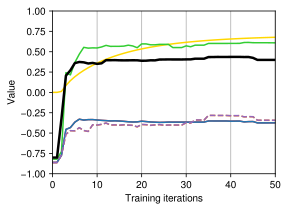

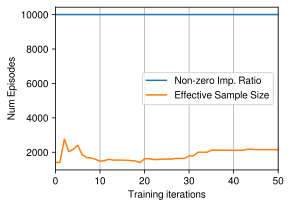

In [19]:
## Plot
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(FQI_value_list, color='gold', label='FQI')
plt.plot(WIS_value_list, color='limegreen', label='WIS')
plt.plot(AM_value_list, color='tab:red', label='AM')
plt.plot(WDR_AM_value_list, '--', color='tab:orange', label='WDR-AM')
plt.plot(FQE_value_list, color='tab:blue', label='FQE')
plt.plot(WDR_FQE_value_list, '--', color='tab:purple', label='WDR-FQE')
plt.plot(true_value_list,  color='k', lw=2.5, label='Ground truth')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.savefig('./fig/run{}/sepsis-tab-3-va10k_eps01.pdf'.format(run), bbox_inches='tight')
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(4,3))
plt.plot(WIS_N_list, label='Non-zero Imp. Ratio')
plt.plot(WIS_ESS_list, label='Effective Sample Size')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Num Episodes')
plt.xlim(0,50)
plt.legend()
plt.savefig('./fig/run{}/sepsis-tab-3-va10k_eps01-ESS.pdf'.format(run), bbox_inches='tight')
plt.show()

In [20]:
results = []
for value_list in [
    FQI_value_list, 
    WIS_value_list,
    AM_value_list,
    WDR_AM_value_list,
    FQE_value_list,
    WDR_FQE_value_list
]:
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman", 'Performance', 'Regret', 'Suboptimality'], 
    index=['FQI', 'WIS', 'AM', 'WDR-AM', 'FQE', 'WDR-FQE']
).T
df_results.to_csv('./results/run{}/sepsis-tab-3-va10k_eps01.csv'.format(run))
df_results

,FQI,WIS,AM,WDR-AM,FQE,WDR-FQE
MSE,0.058928,0.031474,0.544184,0.562136,0.544839,0.560316
Spearman,0.828947,0.720058,0.137716,0.841776,0.136629,0.842229
Performance,0.399209,0.434979,0.373761,0.434260,0.373761,0.434260
Regret,0.036822,0.001052,0.062270,0.001771,0.062270,0.001771
Suboptimality,0.278333,0.242562,0.303781,0.243282,0.303781,0.243282


### va 5k unif + 5k eps01

In [21]:
N_val = 10_000
df_va1 = df_seed2.set_index('pt_id').loc[200_000+run*run_idx_length:200_000+run*run_idx_length + N_val//2 - 1].reset_index()
df_va2 = df_eps01_seed2.set_index('pt_id').loc[200_000+run*run_idx_length:200_000+run*run_idx_length + N_val//2 - 1].reset_index()
df_va2['pt_id'] = df_va2['pt_id'] + 1_000_000
df_va = pd.concat([df_va1, df_va2])

In [22]:
# OPE - WIS/WDR prep
pi_b_val = compute_behavior_policy(df_va)
data_va = format_data_tensor(df_va)

# OPE - WIS
WIS_value_list, WIS_N_list, WIS_ESS_list = zip(*[OPE_WIS(data_va, pi_b_val, π, gamma) for π in tqdm(π_list)])

# OPE - AM
P_val, R_val, isd_val = compute_empirical_MDP(df_va)
AM_V_list = [policy_eval_analytic(P_val.transpose((1,0,2)), R_val, π, gamma) for π in tqdm(π_list)]
AM_value_list = [V @ isd_val for V in tqdm(AM_V_list)]

# OPE - WDR-AM
AM_Q_list = [V2Q(V, P_val.transpose((1,0,2)), R_val, gamma) for V in tqdm(AM_V_list)]
WDR_AM_value_list = [OPE_WDR(data_va, V, Q, pi_b_val, π, gamma) for π, V, Q in tqdm(zip(π_list, AM_V_list, AM_Q_list))]

# OPE - FQE
FQE_Q_list = Parallel(n_jobs=10)(delayed(run_tabular_FQE)(df_va, π, gamma, n_epochs=50) for π in tqdm(π_list))
FQE_V_list = [(Q * π).sum(axis=1) for π, Q in zip(π_list, FQE_Q_list)]

FQE_value_list = [isd_val @ V for V in FQE_V_list]

# OPE - WDR-FQE
WDR_FQE_value_list = [OPE_WDR(data_va, V, Q, pi_b_val, π, gamma) for π, V, Q in tqdm(zip(π_list, FQE_V_list, FQE_Q_list))]

10000it [00:05, 1693.02it/s]
100%|██████████| 51/51 [00:18<00:00,  2.74it/s]
51it [00:00, 51.91it/s]
100%|██████████| 51/51 [00:10<00:00,  4.89it/s]
51it [00:01, 45.83it/s]


In [23]:
all_values_dict = {
    'FQI_value_list': FQI_value_list,
    'WIS_value_list': WIS_value_list,
    'AM_value_list': AM_value_list,
    'FQE_value_list': FQE_value_list,
    'WDR_FQE_value_list': WDR_FQE_value_list,
    'true_value_list': true_value_list,
}

joblib.dump(all_values_dict, './results/run{}/sepsis-tab-3-va10k_mixed.values.joblib'.format(run))

['./results/run9/sepsis-tab-3-va10k_mixed.values.joblib']

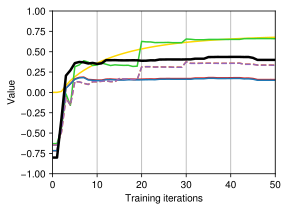

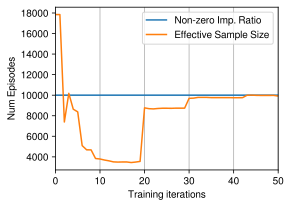

In [24]:
## Plot
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(FQI_value_list, color='gold', label='FQI')
plt.plot(WIS_value_list, color='limegreen', label='WIS')
plt.plot(AM_value_list, color='tab:red', label='AM')
plt.plot(WDR_AM_value_list, '--', color='tab:orange', label='WDR-AM')
plt.plot(FQE_value_list, color='tab:blue', label='FQE')
plt.plot(WDR_FQE_value_list, '--', color='tab:purple', label='WDR-FQE')
plt.plot(true_value_list,  color='k', lw=2.5, label='Ground truth')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.savefig('./fig/run{}/sepsis-tab-3-va10k_mixed.pdf'.format(run), bbox_inches='tight')
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(4,3))
plt.plot(WIS_N_list, label='Non-zero Imp. Ratio')
plt.plot(WIS_ESS_list, label='Effective Sample Size')
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Num Episodes')
plt.xlim(0,50)
plt.legend()
plt.savefig('./fig/run{}/sepsis-tab-3-va10k_mixed-ESS.pdf'.format(run), bbox_inches='tight')
plt.show()

In [25]:
results = []
for value_list in [
    FQI_value_list, 
    WIS_value_list,
    AM_value_list,
    WDR_AM_value_list,
    FQE_value_list,
    WDR_FQE_value_list
]:
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman", 'Performance', 'Regret', 'Suboptimality'], 
    index=['FQI', 'WIS', 'AM', 'WDR-AM', 'FQE', 'WDR-FQE']
).T
df_results.to_csv('./results/run{}/sepsis-tab-3-va10k_mixed.csv'.format(run))
df_results

,FQI,WIS,AM,WDR-AM,FQE,WDR-FQE
MSE,0.058928,0.038650,0.050946,0.027099,0.054576,0.027064
Spearman,0.828947,0.747793,0.753316,0.891756,0.746344,0.891756
Performance,0.399209,0.399173,0.369167,0.405496,0.369167,0.405496
Regret,0.036822,0.036858,0.066864,0.030535,0.066864,0.030535
Suboptimality,0.278333,0.278368,0.308375,0.272046,0.308375,0.272046
